# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

## 1. Download/Load SP500 stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-12-18'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%***********************]  503 of 503 completed


adj close       close        high         low        open  \
date       ticker                                                               
2015-12-21 A        38.225826   40.830002   41.119999   40.439999   40.509998   
           AAL      40.519371   42.400002   42.430000   41.349998   41.349998   
           AAPL     24.428122   26.832500   26.842501   26.392500   26.820000   
           ABBV     39.780033   56.200001   56.259998   55.700001   56.000000   
           ABT      37.911850   44.040001   44.189999   43.570000   44.049999   
...                       ...         ...         ...         ...         ...   
2023-12-15 YUM     128.639999  128.639999  130.830002  128.220001  130.169998   
           ZBH     118.690002  118.690002  118.980003  117.309998  118.000000   
           ZBRA    270.179993  270.179993  280.329987  268.070007  269.170013   
           ZION     43.840000   43.840000   45.820000   43.310001   45.529999   
           ZTS     196.289993  196.289993  199.410004  193.970001  199.410004   

                        volume  
date       ticker               
2015-12-21 A         1734500.0  
           AAL       6597500.0  
           AAPL    190362400.0  
           ABBV      4572100.0  
           ABT       5453300.0  
...                        ...  
2023-12-15 YUM       2667500.0  
           ZBH       4073900.0  
           ZBRA      1025000.0  
           ZION      6252100.0  
           ZTS       4058300.0  

[993845 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [2]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

adj close       close        high         low        open  \
date       ticker                                                               
2015-12-21 A        38.225826   40.830002   41.119999   40.439999   40.509998   
           AAL      40.519371   42.400002   42.430000   41.349998   41.349998   
           AAPL     24.428122   26.832500   26.842501   26.392500   26.820000   
           ABBV     39.780033   56.200001   56.259998   55.700001   56.000000   
           ABT      37.911850   44.040001   44.189999   43.570000   44.049999   
...                       ...         ...         ...         ...         ...   
2023-12-15 YUM     128.639999  128.639999  130.830002  128.220001  130.169998   
           ZBH     118.690002  118.690002  118.980003  117.309998  118.000000   
           ZBRA    270.179993  270.179993  280.329987  268.070007  269.170013   
           ZION     43.840000   43.840000   45.820000   43.310001   45.529999   
           ZTS     196.289993  196.289993  199.410004  193.970001  199.410004   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-12-21 A         1734500.0         -0.001162        NaN       NaN   
           AAL       6597500.0          0.000173        NaN       NaN   
           AAPL    190362400.0         -0.003228        NaN       NaN   
           ABBV      4572100.0         -0.045129        NaN       NaN   
           ABT       5453300.0         -0.008599        NaN       NaN   
...                        ...               ...        ...       ...   
2023-12-15 YUM       2667500.0          0.000149  56.755593  4.822102   
           ZBH       4073900.0          0.000087  63.663439  4.721000   
           ZBRA      1025000.0          0.000994  72.963110  5.362554   
           ZION      6252100.0          0.001034  68.068454  3.494999   
           ZTS       4058300.0          0.000286  68.354513  5.134741   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-12-21 A            NaN       NaN       NaN       NaN      66.302696  
           AAL          NaN       NaN       NaN       NaN     267.326550  
           AAPL         NaN       NaN       NaN       NaN    4650.195849  
           ABBV         NaN       NaN       NaN       NaN     181.878289  
           ABT          NaN       NaN       NaN       NaN     206.744691  
...                     ...       ...       ...       ...            ...  
2023-12-15 YUM     4.851826  4.881549  0.344380  0.649592     343.147198  
           ZBH     4.759185  4.797369 -0.808053  0.937117     483.531201  
           ZBRA    5.470566  5.578577  0.168650  1.282483     276.934492  
           ZION    3.650019  3.805039  0.790845  2.079898     274.092065  
           ZTS     5.214515  5.294290  0.881422  2.650992     796.603680  

[993845 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [3]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-01-31 A           95.369735   35.345051 -0.881558  3.682282  3.532355   
           AAL        475.458010   37.260616  2.115890  3.723517  3.618182   
           AAPL      5981.206805   22.154413 -0.834554  3.215938  3.095448   
           ABBV       460.247960   39.267998  0.293333  3.788067  3.650394   
           ABT        326.006432   32.788799 -0.431856  3.667053  3.508551   
...                          ...         ...       ...       ...       ...   
2023-12-31 YUM        248.674126  128.639999  0.344380  4.881549  4.822102   
           ZBH        219.295151  118.690002 -0.808053  4.797369  4.721000   
           ZBRA       111.271770  270.179993  0.168650  5.578577  5.362554   
           ZION       129.928827   43.840000  0.790845  3.805039  3.494999   
           ZTS        393.542475  196.289993  0.881422  5.294290  5.134741   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-01-31 A       3.607319          0.000336 -0.948422  41.394106  
           AAL     3.670850          0.002147 -1.290857  41.155515  
           AAPL    3.155693         -0.001265 -0.644867  42.544960  
           ABBV    3.719231         -0.035988 -0.225769  45.740989  
           ABT     3.587802         -0.004372 -1.524453  32.811620  
...                     ...               ...       ...        ...  
2023-12-31 YUM     4.851826          0.000149  0.649592  56.755593  
           ZBH     4.759185          0.000087  0.937117  63.663439  
           ZBRA    5.470566          0.000994  1.282483  72.963110  
           ZION    3.650019          0.001034  2.079898  68.068454  
           ZTS     5.214515          0.000286  2.650992  68.354513  

[47434 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [4]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2016-12-31 AAL      45.118103  0.406999  3.899765  3.813338  3.856552   
           AAPL     26.946924 -1.130414  3.364473  3.274855  3.319664   
           ABBV     46.037800 -1.271135  3.863187  3.809937  3.836562   
           ABT      33.897537 -1.191632  3.575095  3.535751  3.555423   
           ACN     105.149284 -0.916340  4.743385  4.641425  4.692405   
...                       ...       ...       ...       ...       ...   
2023-12-31 VRTX    410.679993  2.036093  5.993954  5.786926  5.890440   
           VZ       37.369999 -0.791228  3.688133  3.622033  3.655083   
           WFC      50.310001 -0.317919  3.924365  3.731621  3.827993   
           WMT     152.740005  0.444796  5.066364  5.020500  5.043432   
           XOM     100.900002  0.443359  4.677374  4.589121  4.633247   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2016-12-31 AAL            -0.000637  1.010267  52.919105  
           AAPL           -0.002296 -0.128168  57.499087  
           ABBV           -0.036939 -0.015131  54.830621  
           ABT            -0.005705 -0.364692  45.324704  
           ACN            -0.004741 -0.365090  44.676171  
...                             ...       ...        ...  
2023-12-31 VRTX            0.000358  2.019053  70.953437  
           VZ              0.000161  1.142291  56.758541  
           WFC             0.000136  2.221919  79.391318  
           WMT             0.000064 -1.756853  42.260304  
           XOM             0.000020 -1.366836  43.977286  

[12665 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [10]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
     
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-12-31 AAL      31.599045  1.555332  3.675254  3.378042  3.526648   
           AAPL     37.850143 -0.407687  3.814001  3.589798  3.701900   
           ABBV     72.990082  0.995918  4.329621  4.187710  4.258666   
           ABT      66.510468  0.431422  4.246655  4.131132  4.188894   
           ACN     131.468994  0.063353  5.088718  4.823430  4.956074   
...                       ...       ...       ...       ...       ...   
2023-12-31 VRTX    410.679993  2.036093  5.993954  5.786926  5.890440   
           VZ       37.369999 -0.791228  3.688133  3.622033  3.655083   
           WFC      50.310001 -0.317919  3.924365  3.731621  3.827993   
           WMT     152.740005  0.444796  5.066364  5.020500  5.043432   
           XOM     100.900002  0.443359  4.677374  4.589121  4.633247   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-12-31 AAL             0.000336 -1.359593  43.366382  -0.200448   
           AAPL           -0.000652 -1.348999  37.072886  -0.116698   
           ABBV           -0.019742 -0.023001  57.957289  -0.022064   
           ABT            -0.001919 -0.278410  55.190158  -0.023228   
           ACN            -0.001577 -1.675331  36.633812  -0.142901   
...                             ...       ...        ...        ...   
2023-12-31 VRTX            0.000358  2.019053  70.953437   0.157465   
           VZ              0.000161  1.142291  56.758541  -0.025046   
           WFC             0.000136  2.221919  79.391318   0.128280   
           WMT             0.000064 -1.756853  42.260304  -0.015304   
           XOM             0.000020 -1.366836  43.977286  -0.017909   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-12-31 AAL     -0.041948  -0.079853  -0.026639  -0.051263   -0.038653  
           AAPL    -0.135154  -0.102652  -0.025181  -0.005637   -0.004607  
           ABBV     0.088210  -0.004972   0.002641   0.000530   -0.000801  
           ABT      0.024291  -0.003340   0.030303   0.022655    0.021488  
           ACN     -0.054157  -0.057936  -0.022971  -0.007415   -0.005345  
...                      ...        ...        ...        ...         ...  
2023-12-31 VRTX     0.064956   0.057019   0.026074   0.029884    0.029781  
           VZ       0.031389   0.053552   0.007309   0.001714    0.001499  
           WFC      0.129735   0.074988   0.030650   0.036371    0.019216  
           WMT     -0.031405  -0.013998  -0.003560   0.005157    0.007489  
           XOM     -0.019208  -0.046830  -0.007268  -0.006352   -0.004614  

[8461 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [11]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-12-31 AAL    -0.0957 -0.0288 -0.0184 -0.0002  0.0021  -0.200448
           AAPL   -0.0957 -0.0288 -0.0184 -0.0002  0.0021  -0.116698
           ABBV   -0.0957 -0.0288 -0.0184 -0.0002  0.0021  -0.022064
           ABT    -0.0957 -0.0288 -0.0184 -0.0002  0.0021  -0.023228
           ACN    -0.0957 -0.0288 -0.0184 -0.0002  0.0021  -0.142901
...                   ...     ...     ...     ...     ...        ...
2023-10-31 VRTX   -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.041324
           VZ     -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.107061
           WFC    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.026676
           WMT    -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.021760
           XOM    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.099762

[8178 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [12]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-12-31 AAL    -0.0957 -0.0288 -0.0184 -0.0002  0.0021  -0.200448
           AAPL   -0.0957 -0.0288 -0.0184 -0.0002  0.0021  -0.116698
           ABBV   -0.0957 -0.0288 -0.0184 -0.0002  0.0021  -0.022064
           ABT    -0.0957 -0.0288 -0.0184 -0.0002  0.0021  -0.023228
           ACN    -0.0957 -0.0288 -0.0184 -0.0002  0.0021  -0.142901
...                   ...     ...     ...     ...     ...        ...
2023-10-31 VRTX   -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.041324
           VZ     -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.107061
           WFC    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.026676
           WMT    -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.021760
           XOM    -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.099762

[8157 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [13]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-12-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-10-31 VRTX    0.517128 -0.606799 -0.243918 -0.124630  0.715860
           VZ      0.351250 -0.546801  0.454639  0.271656 -0.153965
           WFC     1.081143  0.342196  2.046440 -0.410924 -1.505579
           WMT     0.684695 -0.330432 -0.418652 -0.131379  0.509320
           XOM     1.018414 -0.780974  1.607742 -0.638642 -0.139784

[8157 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [14]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8181 entries, (Timestamp('2018-12-31 00:00:00', freq='M'), 'AAL') to (Timestamp('2023-12-31 00:00:00', freq='M'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               8181 non-null   float64
 1   bb_high           8181 non-null   float64
 2   bb_low            8181 non-null   float64
 3   bb_mid            8181 non-null   float64
 4   garman_klass_vol  8181 non-null   float64
 5   macd              8181 non-null   float64
 6   rsi               8181 non-null   float64
 7   return_1m         8181 non-null   float64
 8   return_2m         8181 non-null   float64
 9   return_3m         8181 non-null   float64
 10  return_6m         8181 non-null   float64
 11  return_9m         8181 non-null   float64
 12  return_12m        8181 non-null   float64
 13  Mkt-RF            8181 non-null   float64
 14  SMB               8181 non-null   float

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [18]:
data = data.drop('cluster', axis=1)


KeyError: "['cluster'] not found in axis"

In [25]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++')
kmeans.fit(data)
initial_centroids = kmeans.cluster_centers_

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-12-31 AAL     1.555332  3.675254  3.378042  3.526648          0.000336   
           AAPL   -0.407687  3.814001  3.589798  3.701900         -0.000652   
           ABBV    0.995918  4.329621  4.187710  4.258666         -0.019742   
           ABT     0.431422  4.246655  4.131132  4.188894         -0.001919   
           ACN     0.063353  5.088718  4.823430  4.956074         -0.001577   
...                     ...       ...       ...       ...               ...   
2023-12-31 VRTX    2.036093  5.993954  5.786926  5.890440          0.000358   
           VZ     -0.791228  3.688133  3.622033  3.655083          0.000161   
           WFC    -0.317919  3.924365  3.731621  3.827993          0.000136   
           WMT     0.444796  5.066364  5.020500  5.043432          0.000064   
           XOM     0.443359  4.677374  4.589121  4.633247          0.000020   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-12-31 AAL    -1.359593  43.366382  -0.200448  -0.041948  -0.079853   
           AAPL   -1.348999  37.072886  -0.116698  -0.135154  -0.102652   
           ABBV   -0.023001  57.957289  -0.022064   0.088210  -0.004972   
           ABT    -0.278410  55.190158  -0.023228   0.024291  -0.003340   
           ACN    -1.675331  36.633812  -0.142901  -0.054157  -0.057936   
...                     ...        ...        ...        ...        ...   
2023-12-31 VRTX    2.019053  70.953437   0.157465   0.064956   0.057019   
           VZ      1.142291  56.758541  -0.025046   0.031389   0.053552   
           WFC     2.221919  79.391318   0.128280   0.129735   0.074988   
           WMT    -1.756853  42.260304  -0.015304  -0.031405  -0.013998   
           XOM    -1.366836  43.977286  -0.017909  -0.019208  -0.046830   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-12-31 AAL     -0.026639  -0.051263   -0.038653  1.094526  1.756128   
           AAPL    -0.025181  -0.005637   -0.004607  1.323845 -0.376817   
           ABBV     0.002641   0.000530   -0.000801  0.590881  0.425485   
           ABT      0.030303   0.022655    0.021488  0.758733 -0.069656   
           ACN     -0.022971  -0.007415   -0.005345  1.220109 -0.166931   
...                      ...        ...         ...       ...       ...   
2023-12-31 VRTX     0.026074   0.029884    0.029781  0.473544 -0.260317   
           VZ       0.007309   0.001714    0.001499  0.457012 -0.342273   
           WFC      0.030650   0.036371    0.019216  1.144987 -0.199677   
           WMT     -0.003560   0.005157    0.007489  0.659550 -0.482570   
           XOM     -0.007268  -0.006352   -0.004614  1.109952  0.129828   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-12-31 AAL     0.495567  0.500117  0.813735        3  
           AAPL   -0.688879  0.376394  0.751280        0  
           ABBV   -0.225123  0.507178  0.451367        2  
           ABT    -0.454296  0.262244  0.928008        2  
           ACN    -0.253037  0.502535  0.067333        0  
...                     ...       ...       ...      ...  
2023-12-31 VRTX   -0.663827  0.318662  1.030260        1  
           VZ      0.207946  0.133983  0.214972        3  
           WFC     1.608955 -0.765344 -0.951095        1  
           WMT    -0.316208  0.019733  0.684867        0  
           XOM     0.980382 -0.848866  0.331360        0  

[8181 rows x 19 columns]

In [26]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


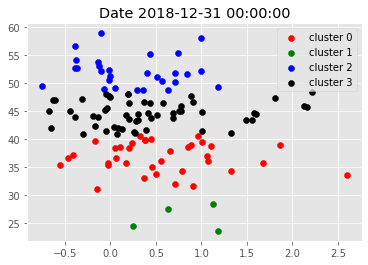

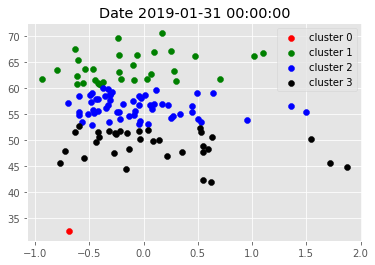

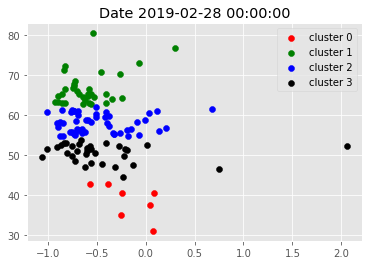

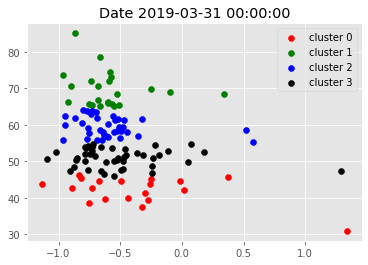

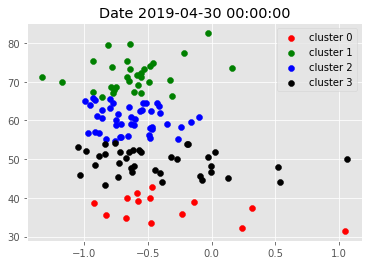

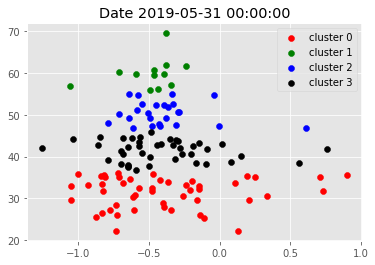

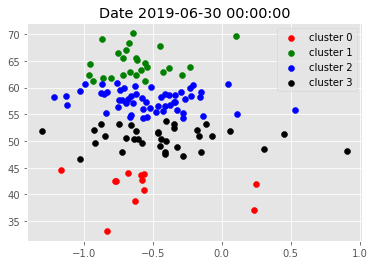

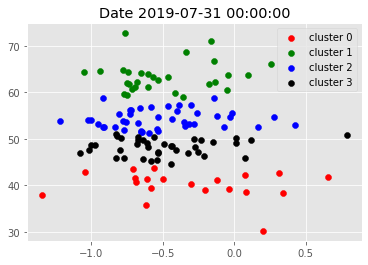

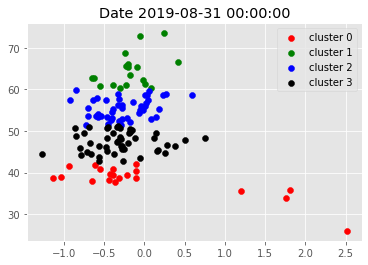

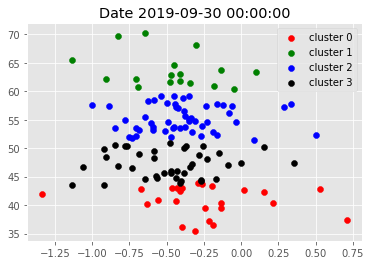

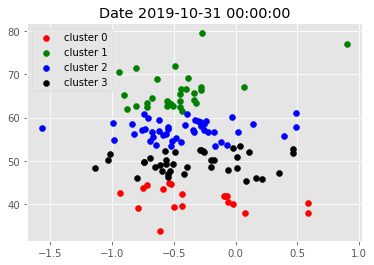

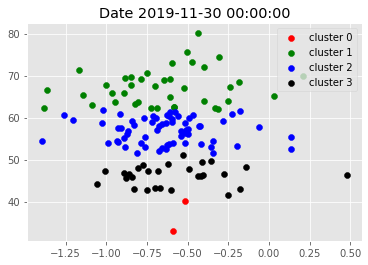

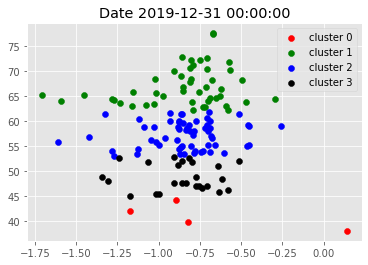

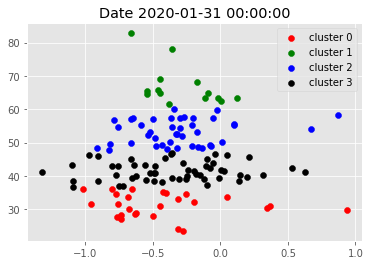

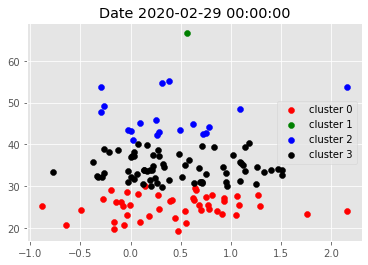

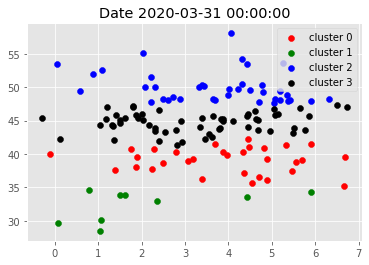

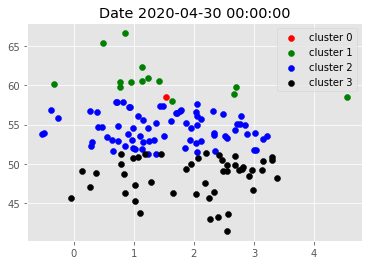

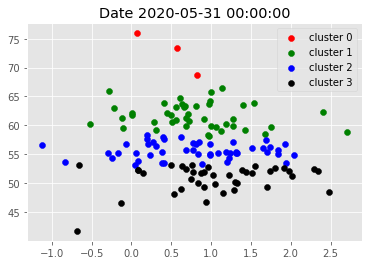

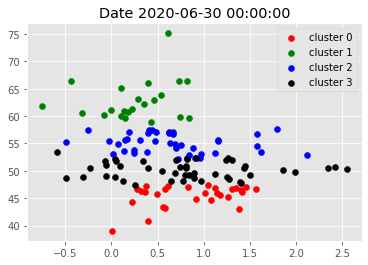

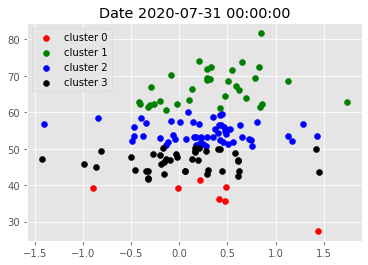

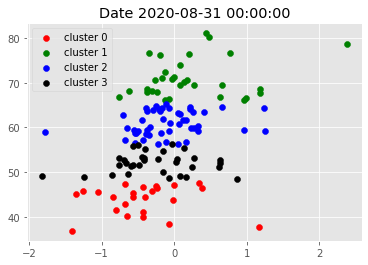

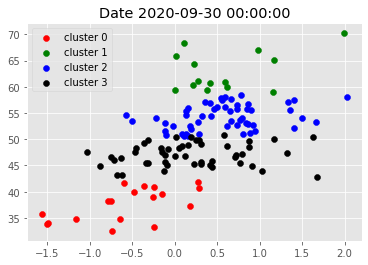

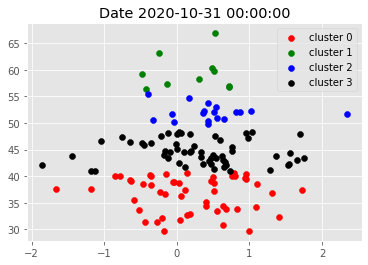

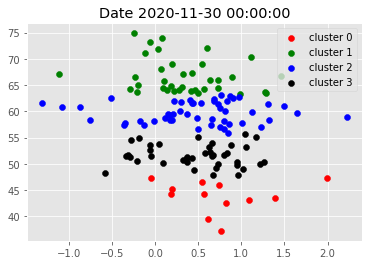

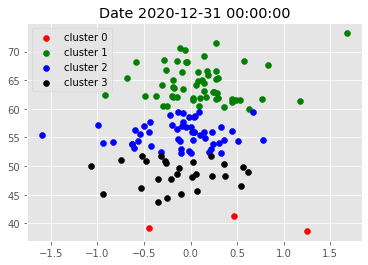

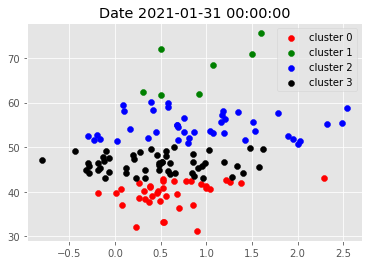

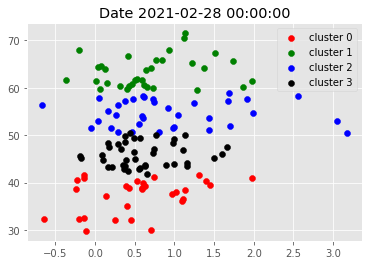

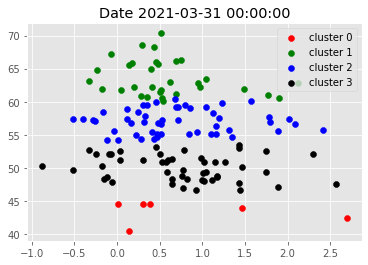

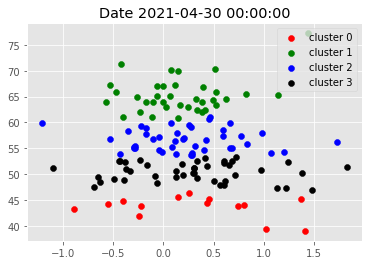

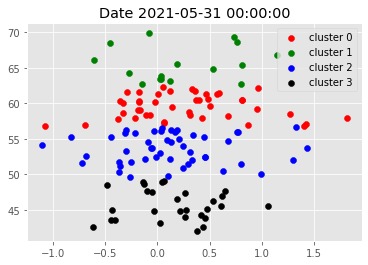

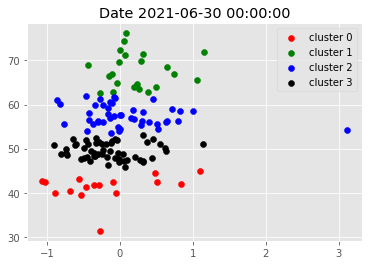

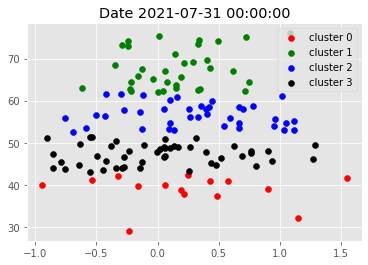

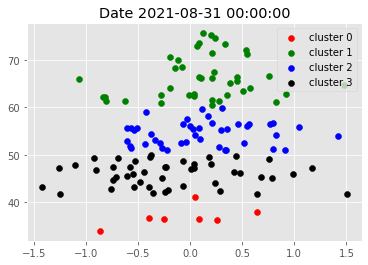

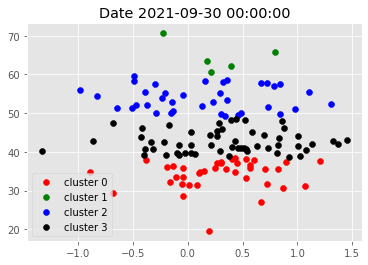

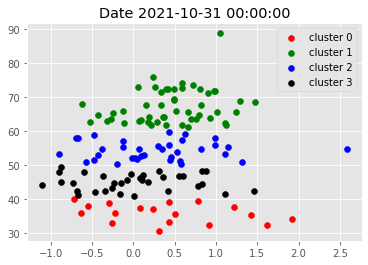

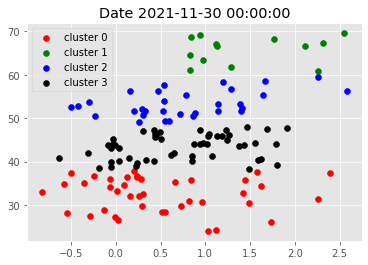

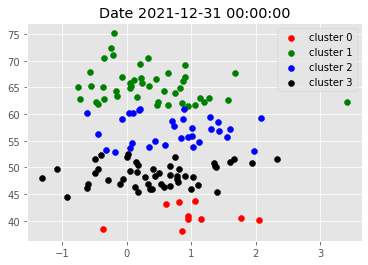

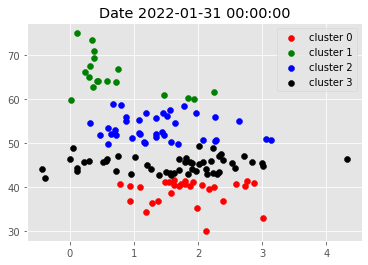

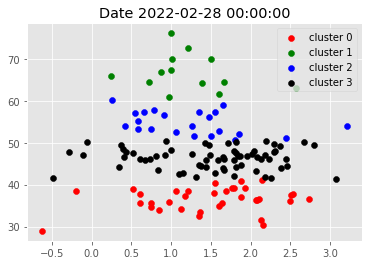

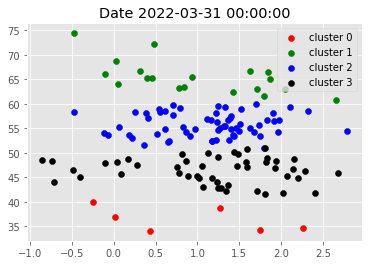

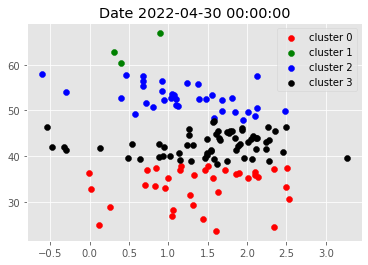

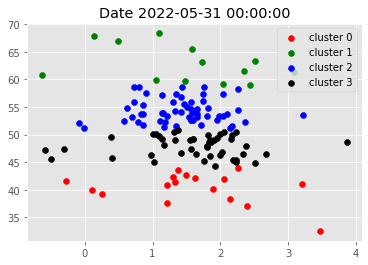

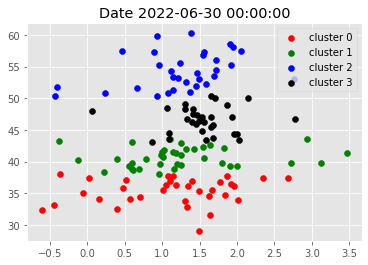

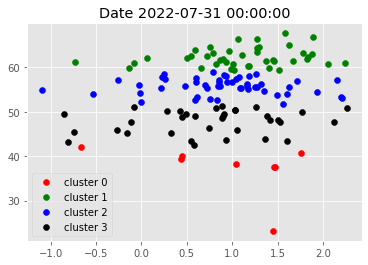

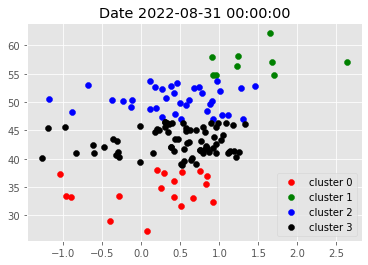

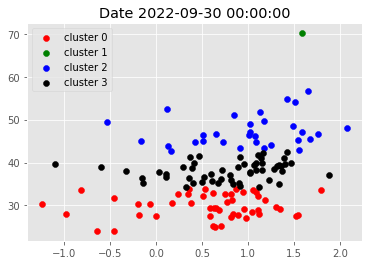

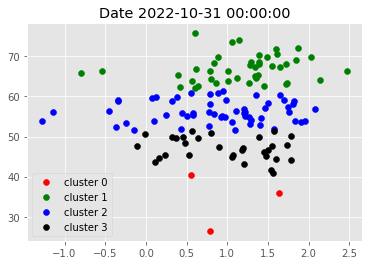

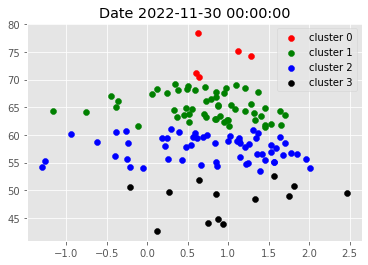

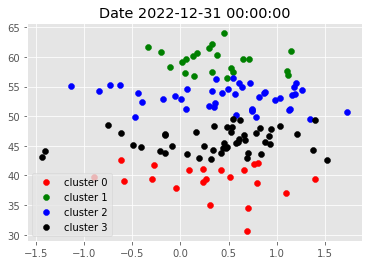

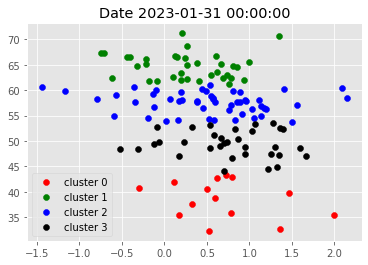

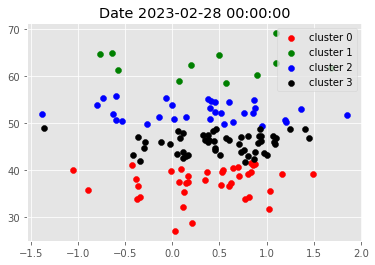

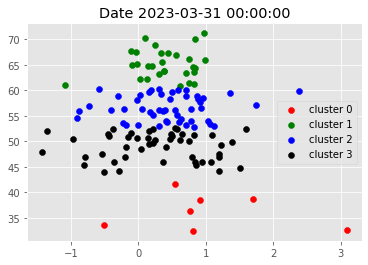

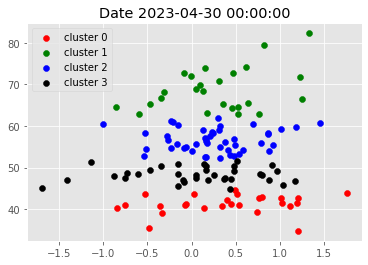

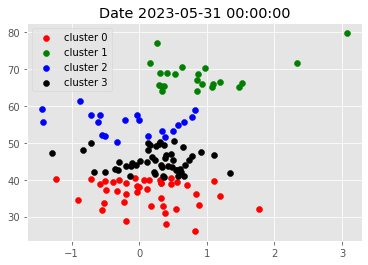

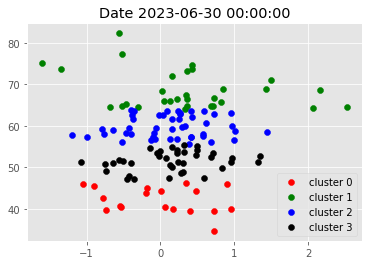

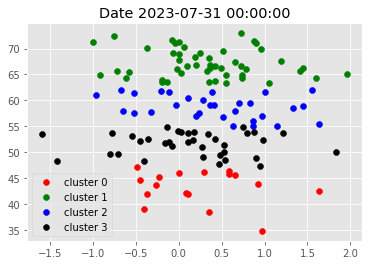

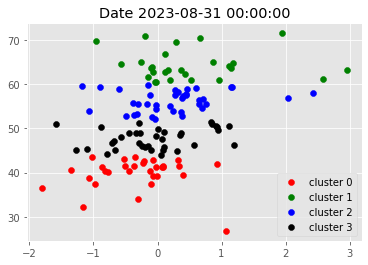

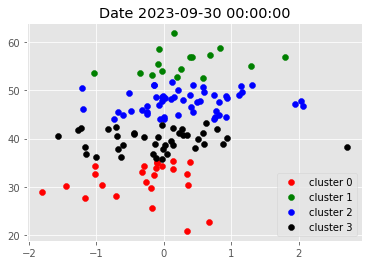

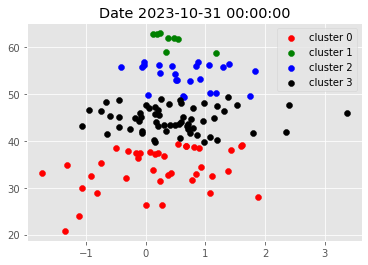

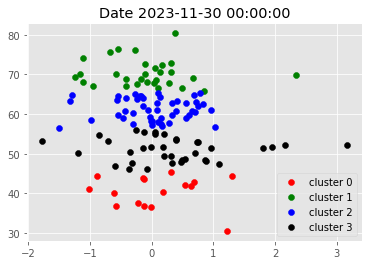

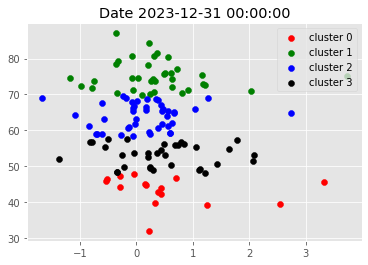

In [27]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Apply pre-defined centroids.

In [28]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [30]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2019-01-01': ['AAL',
  'ADBE',
  'AIG',
  'AMAT',
  'AMZN',
  'BA',
  'BAC',
  'BIIB',
  'BKNG',
  'CMG',
  'COP',
  'COST',
  'CSCO',
  'CVX',
  'DD',
  'DIS',
  'EBAY',
  'ELV',
  'EXPE',
  'FCX',
  'GE',
  'GM',
  'GOOG',
  'GOOGL',
  'HD',
  'IBM',
  'ISRG',
  'KO',
  'KR',
  'MA',
  'MAR',
  'MDT',
  'META',
  'MMM',
  'MS',
  'MSFT',
  'NEE',
  'NFLX',
  'NXPI',
  'ORCL',
  'PEP',
  'QCOM',
  'SCHW',
  'SHW',
  'T',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNH',
  'UNP',
  'UPS',
  'V',
  'VLO',
  'VZ',
  'WYNN'],
 '2019-02-01': ['ABBV',
  'AMGN',
  'BMY',
  'CSX',
  'CVS',
  'DAL',
  'DD',
  'DIS',
  'EOG',
  'FCX',
  'FDX',
  'INTC',
  'JNJ',
  'KR',
  'MCD',
  'MDT',
  'MO',
  'MRK',
  'MS',
  'MSFT',
  'NVDA',
  'ORLY',
  'PFE',
  'PNC',
  'PYPL',
  'STZ',
  'T',
  'TSLA',
  'V',
  'VZ',
  'WBA',
  'WFC',
  'WMT',
  'XOM'],
 '2019-03-01': ['AAL',
  'AIG',
  'AMAT',
  'AMGN',
  'AMZN',
  'BIIB',
  'BRK-B',
  'COP',
  'CTSH',
  'DAL',
  'DD',
  'DIS',
  'EA',
  'EOG',
  'EXPE',

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [38]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [39]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  144 of 144 completed


Adj Close                                                  \
                  AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2018-01-02  51.647568   40.722874   74.990395   53.086956  140.888626   
2018-01-03  51.014023   40.715778   76.163910   53.204342  141.538849   
2018-01-04  51.335667   40.904919   75.729553   53.114040  143.214798   
2018-01-05  51.316177   41.370628   77.047844   53.267551  144.396210   
2018-01-08  50.809349   41.216965   75.813370   53.114040  145.550125   
...               ...         ...         ...         ...         ...   
2023-12-13  14.090000  197.960007  154.300003  107.250000  343.640015   
2023-12-14  14.590000  198.110001  154.880005  108.599998  342.730011   
2023-12-15  14.490000  197.570007  154.039993  107.290001  344.149994   
2023-12-18  14.240000  195.889999  153.419998  108.059998  341.850006   
2023-12-19  14.380000  196.600006  153.770004  108.519997  344.230011   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2018-01-02  177.699997  102.311714  107.120003  50.440163   49.301430  ...   
2018-01-03  181.039993  103.423119  109.379997  50.999668   50.175163  ...   
2018-01-04  183.220001  104.411018  112.070000  51.203129   50.463314  ...   
2018-01-05  185.339996  104.349297  110.839996  51.415058   50.751465  ...   
2018-01-08  185.039993  104.031738  111.419998  51.075970   51.978424  ...   
...                ...         ...         ...        ...         ...  ...   
2023-12-13  624.260010  239.220001  234.910004  67.230003  156.990005  ...   
2023-12-14  584.640015  235.970001  240.809998  66.489998  161.740005  ...   
2023-12-15  584.679993  234.139999  242.289993  66.010002  161.949997  ...   
2023-12-18  599.130005  234.850006  239.139999  66.459999  160.360001  ...   
2023-12-19  601.130005  234.619995  239.080002  67.519997  161.125000  ...   

              Volume                                                           \
                   V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2018-01-02   6080900  3582900  1382000  16045300   6605000  3894000  13819300   
2018-01-03   6946100  3057600  1604000  16662400   7147300  3253300  14203700   
2018-01-04   7805300  2977000  1345100  12062800  12456000  5173100  18740500   
2018-01-05   8590500  2973800  1940000  13348900   9067200  2727400  14217900   
2018-01-08   6660700  2493400  1987000  16212700   5312500  4875300  15569400   
...              ...      ...      ...       ...       ...      ...       ...   
2023-12-13   4859900  4238400  6222500  32473200  19152300  6881900  26549100   
2023-12-14   8168700  4415300  3124900  28551600  23083600  8115000  41115400   
2023-12-15  13373600  9641800  4074700  51715400  22315200  7288100  44098700   
2023-12-18   6040300  3620600  1867300  22048400  11155100  3150400  20529500   
2023-12-19    983435   724186   327451   2647790   2168586   542803   3321173   

                                         
                 WMT     WYNN       XOM  
Date                                     
2018-01-02  10150500  2581200  11469300  
2018-01-03   8903600  3530900  13957700  
2018-01-04   6830400  2708800  10863000  
2018-01-05   7284000  2186600  11047600  
2018-01-08   8843900  1803800  10927100  
...              ...      ...       ...  
2023-12-13  11782900  1935800  19915400  
2023-12-14  10297100  2970100  26165700  
2023-12-15  23332700  3478100  55518700  
2023-12-18   8759100  1486700  21433700  
2023-12-19   1721914   361957   3345587  

[1502 rows x 864 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [40]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2022-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-12-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2019-01-02,0.001053
2019-01-03,-0.021994
2019-01-04,0.041044
2019-01-07,0.018447
2019-01-08,0.009614
...,...
2023-12-13,0.018176
2023-12-14,0.005862
2023-12-15,0.000734


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [41]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2019-01-02,0.001053,0.001040
2019-01-03,-0.021994,-0.024152
2019-01-04,0.041044,0.032947
2019-01-07,0.018447,0.007854
2019-01-08,0.009614,0.009351
...,...,...
2023-12-12,0.009078,0.004557
2023-12-13,0.018176,0.013696
2023-12-14,0.005862,0.003204
2023-12-15,0.000734,-0.001648


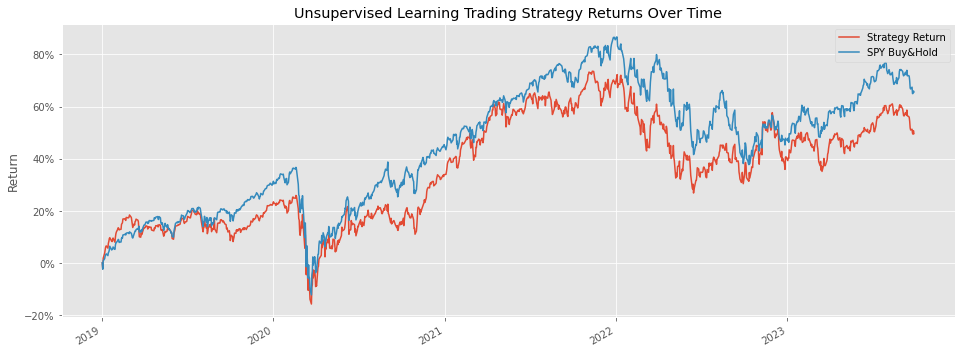

In [42]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


# Twitter Sentiment Investing Strategy

## 1. Load Twitter Sentiment Data

* Load the twitter sentiment dataset, set the index, calculat engagement ratio and filter out stocks with no significant twitter activity.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')

data_folder = r'C:\Users\len\Quant Strategies'

sentiment_df = pd.read_csv(os.path.join(data_folder, 'sentiment_data.csv'))

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

sentiment_df = sentiment_df.set_index(['date', 'symbol'])

sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]

sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

## 2. Aggregate Monthly and calculate average sentiment for the month

* Aggregate on a monthly level and calculate average monthly metric, for the one we choose.

In [55]:
aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                    [['engagement_ratio']].mean())

aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

aggragated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

## 3. Select Top 5 Stocks based on their cross-sectional ranking for each month

* Select top 5 stocks by rank for each month and fix the date to start at beginning of next month.

In [56]:
filtered_df = aggragated_df[aggragated_df['rank']<6].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 D               0.801994   5.0
           FCX             0.841220   4.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.136678   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 FCX             1.138332   2.0
           GILD            0.530886   5.0
           LUV             1.574377   1.0
           MRO             0.581748   4.0
           OXY             1.025579   3.0

## 4. Extract the stocks to form portfolios with at the start of each new month

* Create a dictionary containing start of month and corresponded selected stocks.

In [57]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

## 5. Download fresh stock prices for only selected/shortlisted stocks

In [82]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers=stocks_list,
                        start='2021-01-01',
                        end='2023-03-01')

[*********************100%***********************]  85 of 85 completed

1 Failed download:
- ATVI: No timezone found, symbol may be delisted


## 6. Calculate Portfolio Returns with monthly rebalancing


In [88]:
returns_df = np.log(prices_df['Adj Close']).diff().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
    cols = fixed_dates[start_date]
    
    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
portfolio_df

,portfolio_return
Date,


## 7. Download NASDAQ/QQQ prices and calculate returns to compare to our strategy

In [68]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,


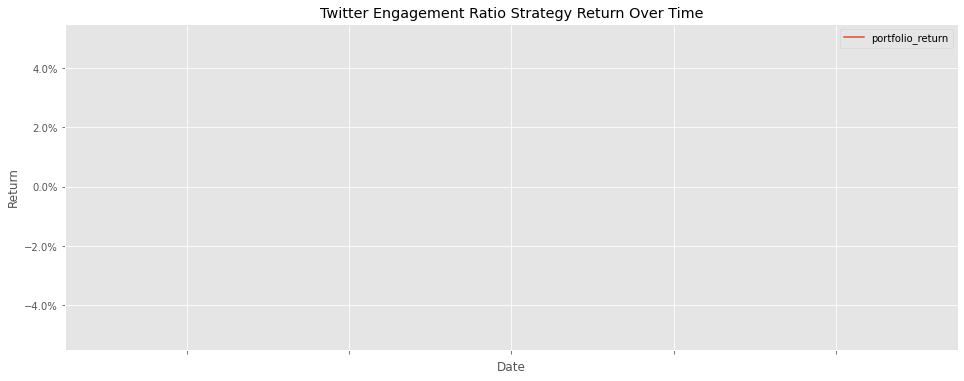

In [74]:
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

# Intraday Strategy Using GARCH Model


* Using simulated daily data and intraday 5-min data.
* Load Daily and 5-minute data.
* Define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window.
* Calculate prediction premium and form a daily signal from it.
* Merge with intraday data and calculate intraday indicators to form the intraday signal.
* Generate the position entry and hold until the end of the day.
* Calculate final strategy returns.

## 1. Load Simulated Daily and Simulated 5-minute data.

* We are loading both datasets, set the indexes and calculate daily log returns.

In [91]:
import matplotlib.pyplot as plt
from arch import arch_model
import pandas_ta
import pandas as pd
import numpy as np
import os

data_folder = r'C:\Users\len\Quant Strategies'

daily_df = pd.read_csv(os.path.join(data_folder, 'simulated_daily_data.csv'))

daily_df = daily_df.drop('Unnamed: 7', axis=1)

daily_df['Date'] = pd.to_datetime(daily_df['Date'])

daily_df = daily_df.set_index('Date')


intraday_5min_df = pd.read_csv(os.path.join(data_folder, 'simulated_5min_data.csv'))

intraday_5min_df = intraday_5min_df.drop('Unnamed: 6', axis=1)

intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])

intraday_5min_df = intraday_5min_df.set_index('datetime')

intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df.index.date)

intraday_5min_df

,open,low,high,close,volume,date
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,2021-09-29
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,2021-09-29
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,2021-09-29
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,2021-09-29
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,2021-09-29
...,...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41,2023-09-20
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42,2023-09-20
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44,2023-09-20


## 2. Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window.

* We are first calculating the 6-month rolling variance and then we are creating a function in a 6-month rolling window to fit a garch model and predict the next day variance.

In [ ]:
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()

daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

daily_df = daily_df['2020':]

def predict_volatility(x):
    
    best_model = arch_model(y=x,
                            p=1,
                            q=3).fit(update_freq=5,
                                     disp='off')
    
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1,0]

    print(x.index[-1])
    
    return variance_forecast

daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))

daily_df = daily_df.dropna()

daily_df

2020-06-28 00:00:00
2020-06-29 00:00:00
2020-06-30 00:00:00
2020-07-01 00:00:00
2020-07-02 00:00:00
2020-07-03 00:00:00
2020-07-04 00:00:00
2020-07-05 00:00:00
2020-07-06 00:00:00
2020-07-07 00:00:00
2020-07-08 00:00:00
2020-07-09 00:00:00
2020-07-10 00:00:00
2020-07-11 00:00:00
2020-07-12 00:00:00
2020-07-13 00:00:00
2020-07-14 00:00:00
2020-07-15 00:00:00
2020-07-16 00:00:00
2020-07-17 00:00:00
2020-07-18 00:00:00
2020-07-19 00:00:00
2020-07-20 00:00:00
2020-07-21 00:00:00
2020-07-22 00:00:00
2020-07-23 00:00:00
2020-07-24 00:00:00
2020-07-25 00:00:00
2020-07-26 00:00:00
2020-07-27 00:00:00
2020-07-28 00:00:00
2020-07-29 00:00:00
2020-07-30 00:00:00
2020-07-31 00:00:00
2020-08-01 00:00:00
2020-08-02 00:00:00
2020-08-03 00:00:00
2020-08-04 00:00:00
2020-08-05 00:00:00
2020-08-06 00:00:00
2020-08-07 00:00:00
2020-08-08 00:00:00
2020-08-09 00:00:00
2020-08-10 00:00:00
2020-08-11 00:00:00
2020-08-12 00:00:00
2020-08-13 00:00:00
2020-08-14 00:00:00
2020-08-15 00:00:00
2020-08-16 00:00:00


C:\Anaconda\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Anaconda\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2020-12-24 00:00:00
2020-12-25 00:00:00
2020-12-26 00:00:00
2020-12-27 00:00:00
2020-12-28 00:00:00
2020-12-29 00:00:00
2020-12-30 00:00:00


C:\Anaconda\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Anaconda\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2020-12-31 00:00:00
2021-01-01 00:00:00
2021-01-02 00:00:00
2021-01-03 00:00:00
2021-01-04 00:00:00
2021-01-05 00:00:00


C:\Anaconda\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Anaconda\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-01-06 00:00:00
2021-01-07 00:00:00
2021-01-08 00:00:00
2021-01-09 00:00:00
2021-01-10 00:00:00


C:\Anaconda\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-01-11 00:00:00
2021-01-12 00:00:00
2021-01-13 00:00:00
2021-01-14 00:00:00
2021-01-15 00:00:00
2021-01-16 00:00:00
2021-01-17 00:00:00
2021-01-18 00:00:00
2021-01-19 00:00:00
2021-01-20 00:00:00
2021-01-21 00:00:00
2021-01-22 00:00:00
2021-01-23 00:00:00
2021-01-24 00:00:00
2021-01-25 00:00:00
2021-01-26 00:00:00
2021-01-27 00:00:00
2021-01-28 00:00:00
2021-01-29 00:00:00
2021-01-30 00:00:00
2021-01-31 00:00:00
2021-02-01 00:00:00
2021-02-02 00:00:00
2021-02-03 00:00:00
2021-02-04 00:00:00
2021-02-05 00:00:00
2021-02-06 00:00:00
2021-02-07 00:00:00
2021-02-08 00:00:00
2021-02-09 00:00:00
2021-02-10 00:00:00
2021-02-11 00:00:00
2021-02-12 00:00:00
2021-02-13 00:00:00
2021-02-14 00:00:00
2021-02-15 00:00:00
2021-02-16 00:00:00
2021-02-17 00:00:00
2021-02-18 00:00:00
2021-02-19 00:00:00
2021-02-20 00:00:00
2021-02-21 00:00:00
2021-02-22 00:00:00
2021-02-23 00:00:00
2021-02-24 00:00:00
2021-02-25 00:00:00
2021-02-26 00:00:00
2021-02-27 00:00:00
2021-02-28 00:00:00
2021-03-01 00:00:00


C:\Anaconda\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-03-08 00:00:00
2021-03-09 00:00:00
2021-03-10 00:00:00
2021-03-11 00:00:00
2021-03-12 00:00:00
2021-03-13 00:00:00


C:\Anaconda\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Anaconda\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-03-14 00:00:00
2021-03-15 00:00:00
2021-03-16 00:00:00
2021-03-17 00:00:00
2021-03-18 00:00:00
2021-03-19 00:00:00
2021-03-20 00:00:00
2021-03-21 00:00:00
2021-03-22 00:00:00
2021-03-23 00:00:00
2021-03-24 00:00:00
2021-03-25 00:00:00
2021-03-26 00:00:00
2021-03-27 00:00:00
2021-03-28 00:00:00
2021-03-29 00:00:00
2021-03-30 00:00:00
2021-03-31 00:00:00
2021-04-01 00:00:00
2021-04-02 00:00:00
2021-04-03 00:00:00
2021-04-04 00:00:00
2021-04-05 00:00:00
2021-04-06 00:00:00
2021-04-07 00:00:00
2021-04-08 00:00:00
2021-04-09 00:00:00
2021-04-10 00:00:00
2021-04-11 00:00:00
2021-04-12 00:00:00
2021-04-13 00:00:00
2021-04-14 00:00:00
2021-04-15 00:00:00
2021-04-16 00:00:00
2021-04-17 00:00:00
2021-04-18 00:00:00
2021-04-19 00:00:00
2021-04-20 00:00:00
2021-04-21 00:00:00
2021-04-22 00:00:00
2021-04-23 00:00:00
2021-04-24 00:00:00
2021-04-25 00:00:00
2021-04-26 00:00:00
2021-04-27 00:00:00
2021-04-28 00:00:00
2021-04-29 00:00:00
2021-04-30 00:00:00
2021-05-01 00:00:00
2021-05-02 00:00:00


2022-04-30 00:00:00
2022-05-01 00:00:00
2022-05-02 00:00:00
2022-05-03 00:00:00
2022-05-04 00:00:00
2022-05-05 00:00:00
2022-05-06 00:00:00
2022-05-07 00:00:00
2022-05-08 00:00:00
2022-05-09 00:00:00
2022-05-10 00:00:00
2022-05-11 00:00:00
2022-05-12 00:00:00
2022-05-13 00:00:00
2022-05-14 00:00:00
2022-05-15 00:00:00
2022-05-16 00:00:00
2022-05-17 00:00:00
2022-05-18 00:00:00
2022-05-19 00:00:00
2022-05-20 00:00:00
2022-05-21 00:00:00
2022-05-22 00:00:00
2022-05-23 00:00:00
2022-05-24 00:00:00
2022-05-25 00:00:00
2022-05-26 00:00:00
2022-05-27 00:00:00
2022-05-28 00:00:00
2022-05-29 00:00:00
2022-05-30 00:00:00
2022-05-31 00:00:00
2022-06-01 00:00:00
2022-06-02 00:00:00
2022-06-03 00:00:00
2022-06-04 00:00:00
2022-06-05 00:00:00
2022-06-06 00:00:00
2022-06-07 00:00:00
2022-06-08 00:00:00
2022-06-09 00:00:00
2022-06-10 00:00:00


C:\Anaconda\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2022-06-11 00:00:00
2022-06-12 00:00:00
2022-06-13 00:00:00
2022-06-14 00:00:00
2022-06-15 00:00:00
2022-06-16 00:00:00
2022-06-17 00:00:00
2022-06-18 00:00:00
2022-06-19 00:00:00
2022-06-20 00:00:00
2022-06-21 00:00:00
2022-06-22 00:00:00
2022-06-23 00:00:00
2022-06-24 00:00:00
2022-06-25 00:00:00
2022-06-26 00:00:00
2022-06-27 00:00:00
2022-06-28 00:00:00
2022-06-29 00:00:00
2022-06-30 00:00:00
2022-07-01 00:00:00
2022-07-02 00:00:00
2022-07-03 00:00:00
2022-07-04 00:00:00
2022-07-05 00:00:00
2022-07-06 00:00:00
2022-07-07 00:00:00
2022-07-08 00:00:00
2022-07-09 00:00:00
2022-07-10 00:00:00
2022-07-11 00:00:00
2022-07-12 00:00:00
2022-07-13 00:00:00
2022-07-14 00:00:00
2022-07-15 00:00:00
2022-07-16 00:00:00
2022-07-17 00:00:00
2022-07-18 00:00:00
2022-07-19 00:00:00
2022-07-20 00:00:00
2022-07-21 00:00:00
2022-07-22 00:00:00
2022-07-23 00:00:00
2022-07-24 00:00:00
2022-07-25 00:00:00
2022-07-26 00:00:00
2022-07-27 00:00:00
2022-07-28 00:00:00
2022-07-29 00:00:00
2022-07-30 00:00:00


## 3. Calculate prediction premium and form a daily signal from it.

* We are calculating the prediction premium. And calculate its 6-month rolling standard deviation.

* From this we are creating our daily signal.

In [ ]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']

daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std'])
                                         else (-1 if (x['prediction_premium']<x['premium_std']*-1) else np.nan),
                                         axis=1)

daily_df['signal_daily'] = daily_df['signal_daily'].shift()

daily_df

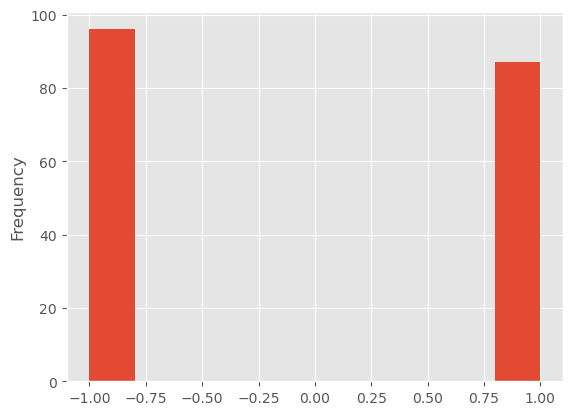

In [28]:
plt.style.use('ggplot')

daily_df['signal_daily'].plot(kind='hist')

plt.show()

## 4. Merge with intraday data and calculate intraday indicators to form the intraday signal.

* Calculate all intraday indicators and intraday signal.

In [ ]:
final_df = intraday_5min_df.reset_index()\
                            .merge(daily_df[['signal_daily']].reset_index(),
                                   left_on='date',
                                   right_on='Date')\
                            .drop(['date','Date'], axis=1)\
                            .set_index('datetime')

final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)

final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
                                                            (x['close']>x['uband'])
                                             else (-1 if (x['rsi']<30)&
                                                         (x['close']<x['lband']) else np.nan),
                                             axis=1)

final_df['return'] = np.log(final_df['close']).diff()

final_df

## 5. Generate the position entry and hold until the end of the day.

In [55]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                        else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
                                        axis=1)

final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                  .transform(lambda x: x.ffill())

final_df['forward_return'] = final_df['return'].shift(-1)

final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()

## 6. Calculate final strategy returns.

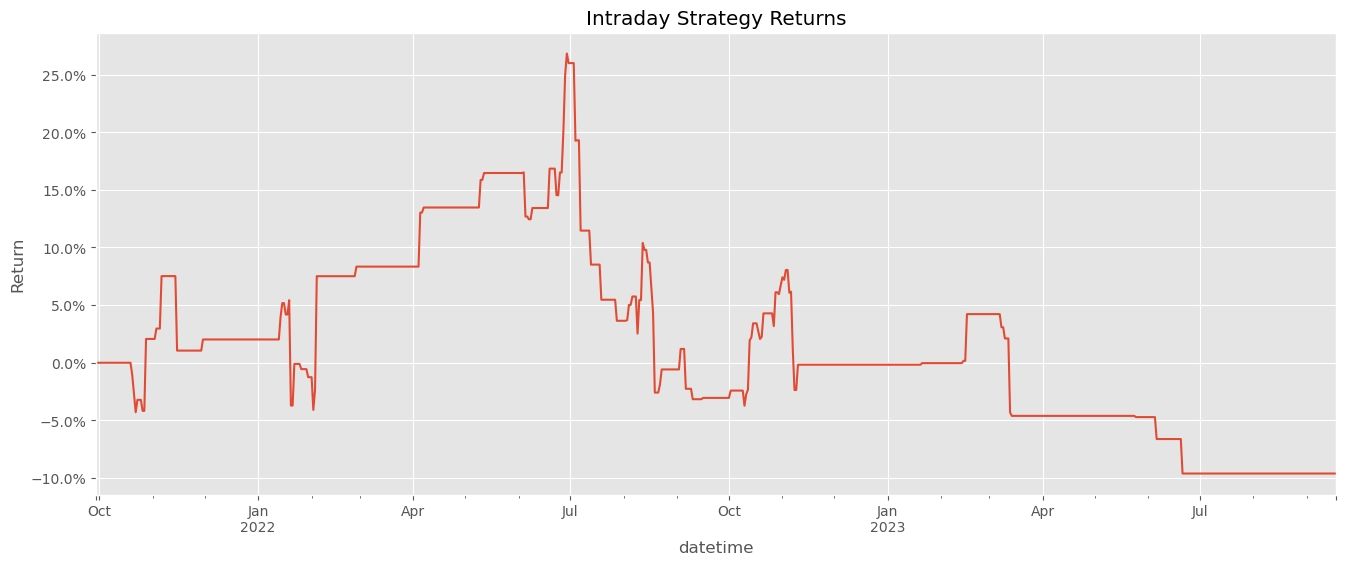

In [56]:
import matplotlib.ticker as mtick

strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

strategy_cumulative_return.plot(figsize=(16,6))

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
                                                                            